<a href="https://colab.research.google.com/github/pushkarsingh-001/Car_price_prediction/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **About Dataset**

Car Price Prediction Dataset Description:
This dataset contains 10,000 entries created for the purpose of predicting car prices. Each row represents information about a car and its price. The descriptions of the columns are as follows:

## **Columns Descriptions:**

* **Brand:** Specifies the brand of the car (e.g., Toyota, BMW, Ford).

* **Model:** Specifies the model of the car (e.g., Corolla, Focus, X5).

* **Year:** The production year of the car. Newer years typically indicate higher prices.

* **Engine_Size:** Specifies the engine size in liters (L). Larger engines generally correlate with higher prices.

* **Fuel_Type:** indicates the type of fuel used by the car:

* **Transmission**: The type of transmission in the car:

* **Mileage:** The total distance the car has traveled, measured in kilometers. Lower mileage generally indicates a higher price.

* **Doors:** The number of doors in the car. Commonly 2, 3, 4, or 5 doors.

* **Owner_Count:** The number of previous owners of the car. Fewer owners generally indicate a higher price.

* **Price:** The estimated selling price of the car. It is calculated based on several factors such as production year, engine size, mileage, fuel type, and transmission.

# **1. Import Required Libraries**

In [7]:
%pip install lightgbm

In [8]:
%pip install catboost

In [70]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.4 MB/s eta 0:00:00


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor # Added LightGBM
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # Removed LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor # Added XGBoost
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

import warnings
warnings.simplefilter(action="ignore")

# **2. Adjusting Row Column Settings**

In [10]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# **3. Loading the data Set**

In [11]:
df = pd.read_csv('car_price_dataset.csv')

# **4. Exploratory Data Analysis**

In [12]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_df = df.select_dtypes(include='number')
    # quantile() işlemi
    quantiles = numeric_df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T
    print(quantiles)

In [13]:
check_df(df)

##################### Shape #####################
(10000, 10)
##################### Types #####################
Brand            object
Model            object
Year              int64
Engine_Size     float64
Fuel_Type        object
Transmission     object
Mileage           int64
Doors             int64
Owner_Count       int64
Price             int64
dtype: object
##################### Head #####################
        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020        4.200    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012        2.000    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020        4.200    Diesel       Automatic   231440   
3        Audi      Q5  2023        2.000  Electric          Manual   160971   
4  Volkswagen    Golf  2003        2.600    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4         

In [14]:
df

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.200,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.000,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.200,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.000,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.600,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.700,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.400,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.000,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.400,Hybrid,Automatic,225772,4,1,4084


# **5. Capturing / Detecting Numeric and Categorical Variables**

In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=31):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [16]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 10000
Variables: 10
cat_cols: 6
num_cols: 4
cat_but_car: 0
num_but_cat: 2


In [17]:
cat_cols

['Brand', 'Model', 'Fuel_Type', 'Transmission', 'Doors', 'Owner_Count']

In [18]:
num_cols

['Year', 'Engine_Size', 'Mileage', 'Price']

In [19]:
cat_but_car

[]

In [20]:
num_but_cat

['Doors', 'Owner_Count']

In [21]:
df["Model"].nunique()

30

# **6. Analysis of Categorical Variables**

In [22]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette="Set2")
        plt.xticks(rotation=45)
        plt.show(block=True)

            Brand  Ratio
Brand                   
Ford         1048 10.480
Audi         1038 10.380
Volkswagen   1020 10.200
Honda        1009 10.090
Chevrolet    1003 10.030
BMW           999  9.990
Hyundai       995  9.950
Kia           976  9.760
Toyota        970  9.700
Mercedes      942  9.420
##########################################


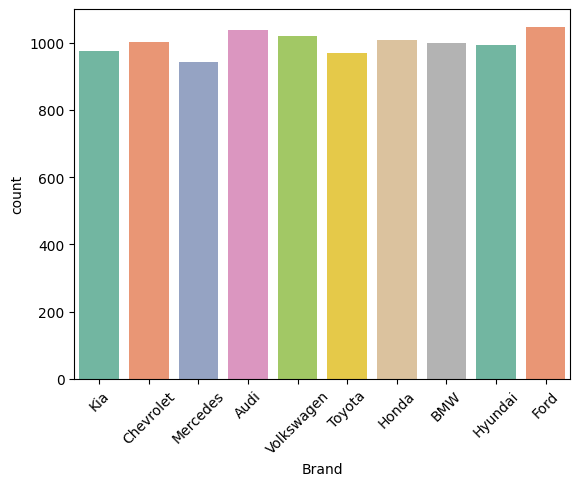

          Model  Ratio
Model                 
Accord      365  3.650
Fiesta      363  3.630
Impala      355  3.550
5 Series    353  3.530
Tiguan      352  3.520
...         ...    ...
GLA         315  3.150
Sportage    313  3.130
X5          311  3.110
CR-V        308  3.080
C-Class     306  3.060

[30 rows x 2 columns]
##########################################


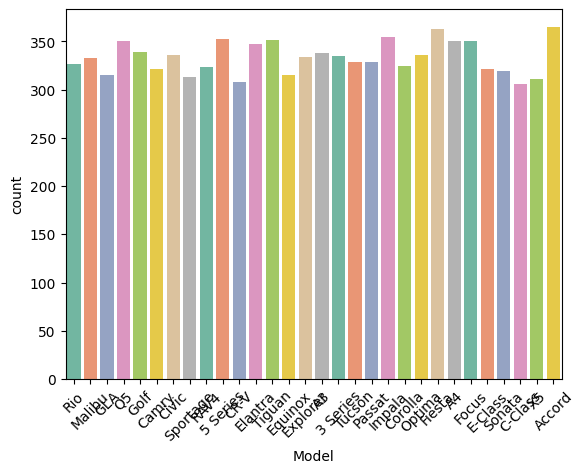

           Fuel_Type  Ratio
Fuel_Type                  
Electric        2625 26.250
Diesel          2512 25.120
Hybrid          2453 24.530
Petrol          2410 24.100
##########################################


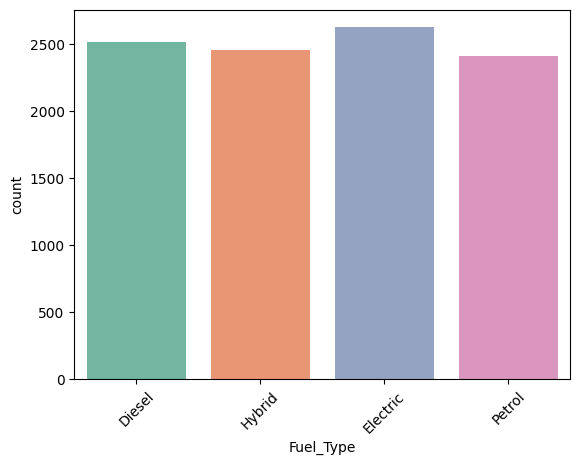

                Transmission  Ratio
Transmission                       
Manual                  3372 33.720
Automatic               3317 33.170
Semi-Automatic          3311 33.110
##########################################


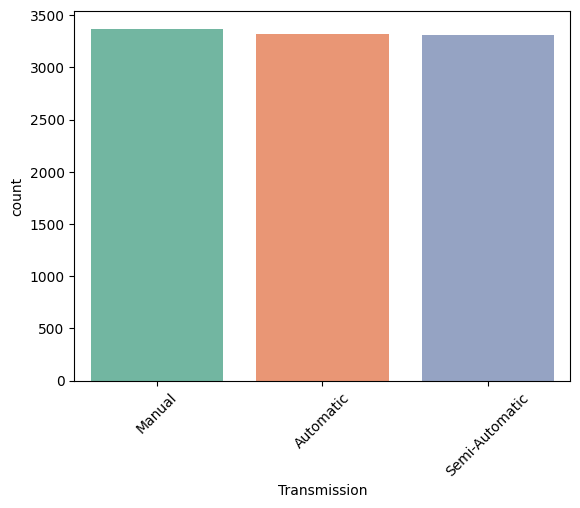

       Doors  Ratio
Doors              
3       2575 25.750
4       2514 25.140
5       2456 24.560
2       2455 24.550
##########################################


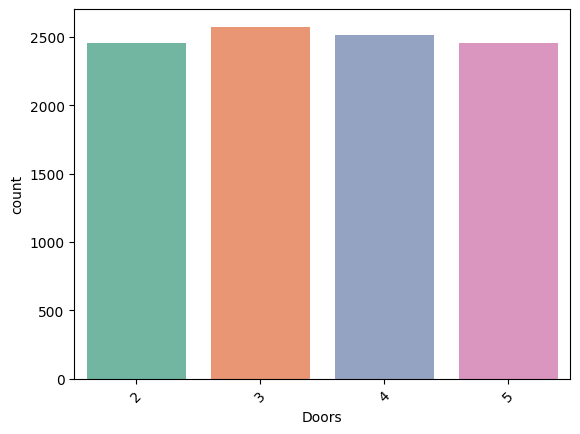

             Owner_Count  Ratio
Owner_Count                    
5                   2036 20.360
1                   2036 20.360
2                   2020 20.200
3                   1977 19.770
4                   1931 19.310
##########################################


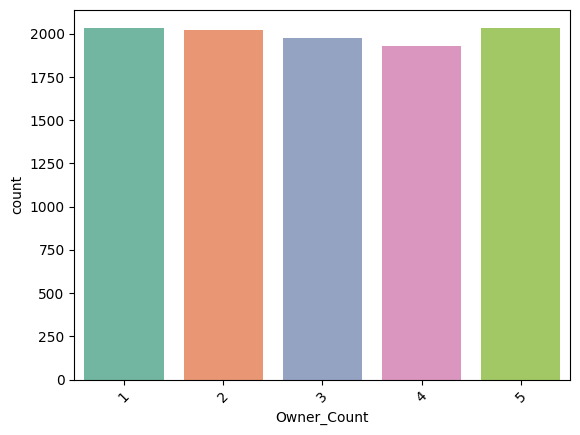

In [23]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

# **7. Analysis of Numerical Variables**

In [24]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        sns.histplot(data=dataframe, x=col_name, bins=20, kde=True, color="blue")
        plt.xticks(rotation=45)
        plt.show(block=True)

count   10000.000
mean     2011.544
std         6.898
min      2000.000
5%       2001.000
10%      2002.000
20%      2004.000
30%      2007.000
40%      2009.000
50%      2012.000
60%      2014.000
70%      2016.000
80%      2019.000
90%      2021.000
95%      2022.000
99%      2023.000
max      2023.000
Name: Year, dtype: float64


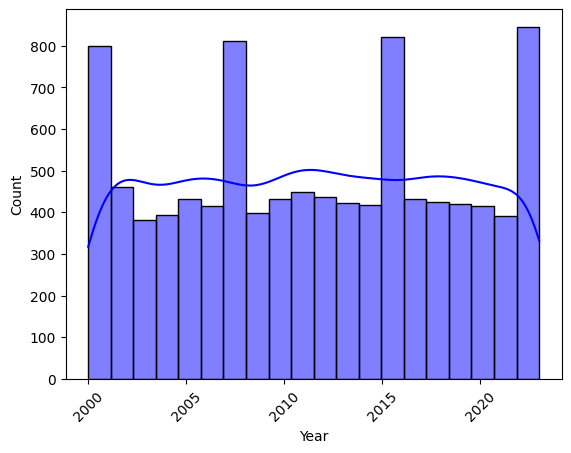

count   10000.000
mean        3.001
std         1.149
min         1.000
5%          1.200
10%         1.400
20%         1.800
30%         2.200
40%         2.600
50%         3.000
60%         3.400
70%         3.800
80%         4.200
90%         4.600
95%         4.800
99%         5.000
max         5.000
Name: Engine_Size, dtype: float64


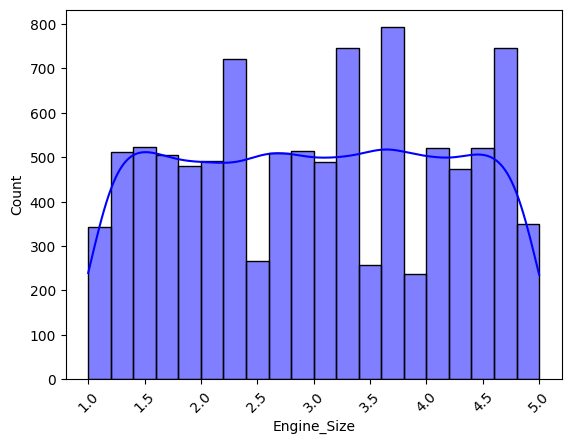

count    10000.000
mean    149239.112
std      86322.349
min         25.000
5%       14336.200
10%      29586.500
20%      59307.000
30%      89633.600
40%     119878.200
50%     149587.000
60%     179242.400
70%     208518.000
80%     238265.600
90%     269373.400
95%     284443.700
99%     296474.030
max     299947.000
Name: Mileage, dtype: float64


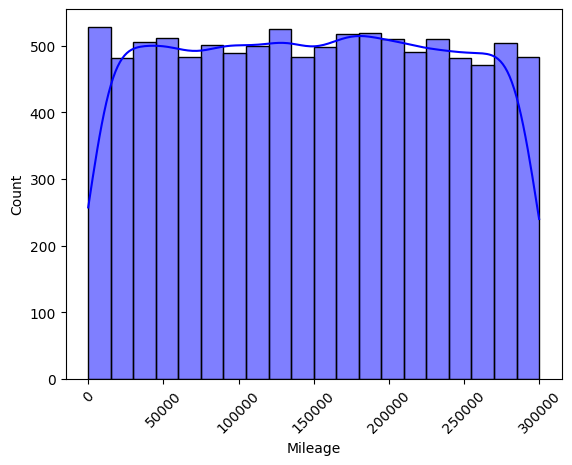

count   10000.000
mean     8852.964
std      3112.597
min      2000.000
5%       3655.000
10%      4672.400
20%      6067.400
30%      7127.700
40%      8038.000
50%      8858.500
60%      9701.400
70%     10577.000
80%     11602.600
90%     12945.300
95%     13981.050
99%     15745.080
max     18301.000
Name: Price, dtype: float64


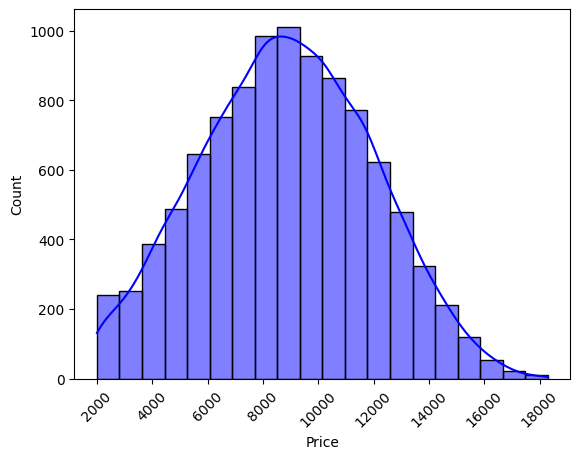

In [25]:
for col in num_cols:
    num_summary(df, col, plot=True)

# **8. Analysis of Categorical Variables by Target**

In [26]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe, palette="Set2")
        plt.xticks(rotation=45)
        plt.show(block=True)

            TARGET_MEAN
Brand                  
Audi           8929.374
BMW            8704.068
Chevrolet      9015.684
Ford           8852.571
Honda          8665.597
Hyundai        8778.279
Kia            8880.086
Mercedes       8980.087
Toyota         8798.185
Volkswagen     8928.377




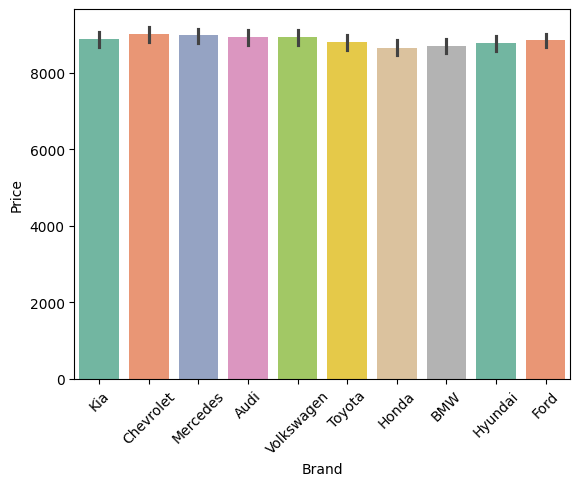

          TARGET_MEAN
Model                
3 Series     8854.752
5 Series     8669.218
A3           8912.317
A4           8919.963
Accord       8743.762
...               ...
Sonata       8740.831
Sportage     8867.636
Tiguan       9098.864
Tucson       8789.070
X5           8581.312

[30 rows x 1 columns]




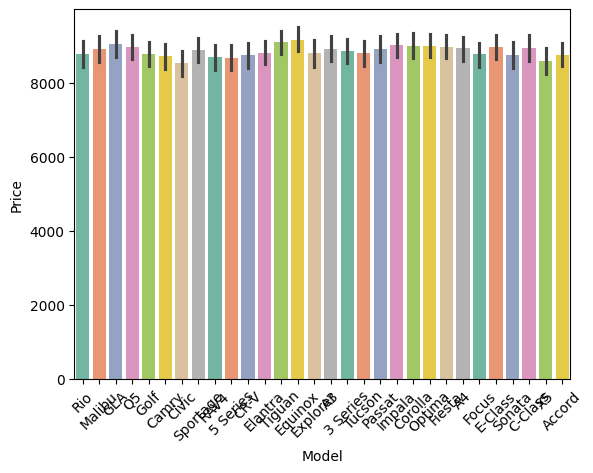

           TARGET_MEAN
Fuel_Type             
Diesel        8117.336
Electric     10032.220
Hybrid        9113.030
Petrol        8070.562




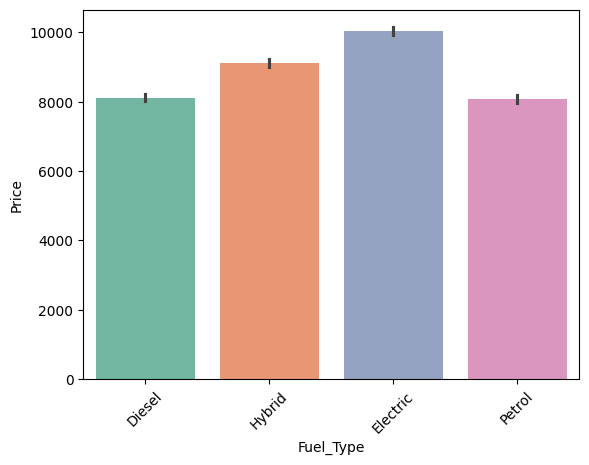

                TARGET_MEAN
Transmission               
Automatic          9938.253
Manual             8363.426
Semi-Automatic     8264.266




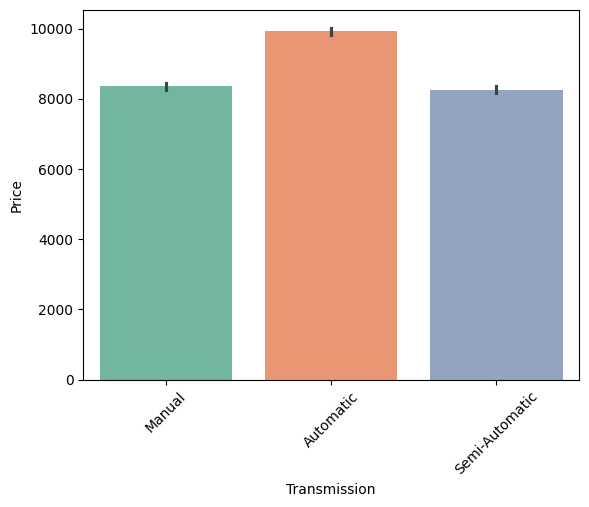

       TARGET_MEAN
Doors             
2         8928.931
3         8746.447
4         8841.588
5         8900.353




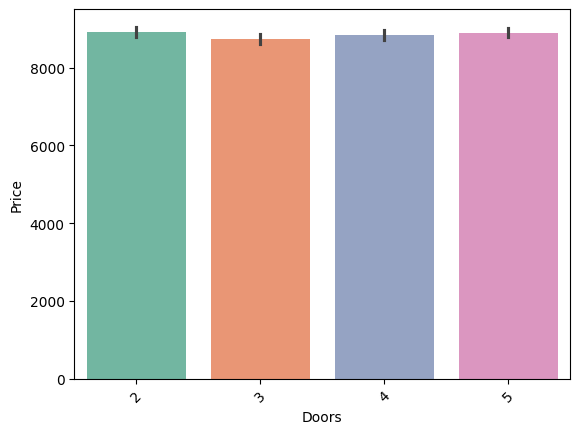

             TARGET_MEAN
Owner_Count             
1               8841.374
2               8847.258
3               8847.919
4               8869.173
5               8859.742




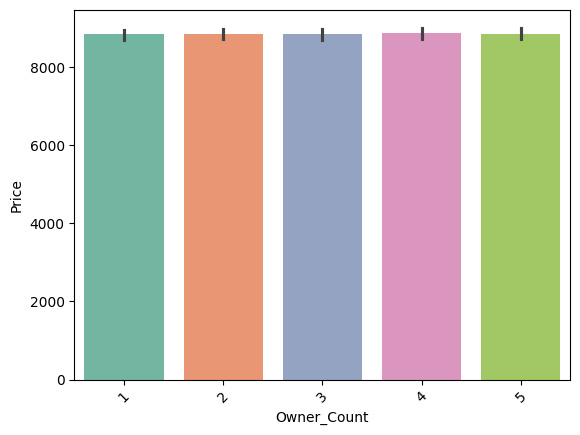

In [27]:
for col in cat_cols:
    target_summary_with_cat(df, "Price", col, plot=True)

# **9. Analysis of Numeric Variables by Target**

In [28]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

In [29]:
for col in num_cols:
    target_summary_with_num(df, "Price", col, plot=False)

       Year_mean
Price           
2000    2001.742
2007    2008.000
2019    2007.000
2032    2002.000
2042    2001.000
...          ...
17899   2023.000
17906   2022.000
18017   2020.000
18255   2023.000
18301   2021.000

[6661 rows x 1 columns]


       Engine_Size_mean
Price                  
2000              1.745
2007              1.300
2019              1.400
2032              2.200
2042              1.400
...                 ...
17899             4.600
17906             4.000
18017             4.800
18255             5.000
18301             4.700

[6661 rows x 1 columns]


       Mileage_mean
Price              
2000     262524.215
2007     289632.000
2019     279031.000
2032     243388.000
2042     237884.000
...             ...
17899     10046.000
17906     14658.000
18017     19112.000
18255     12234.000
18301     14924.000

[6661 rows x 1 columns]


       Price_mean
Price            
2000     2000.000
2007     2007.000
2019     2019.000
2032     2032.000
2042     2042.000


# **10. Correlation Analysis**

In [30]:
def high_correlated_cols2(dataframe, plot=False, corr_th=0.70):
    # Sadece sayısal sütunları seçelim
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Korelasyon matrisi oluştur
    corr = numeric_df.corr()
    cor_matrix = corr.abs()

    # Üst üçgen matrisini seç (gereksiz tekrarları kaldırmak için)
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Korelasyonu eşikten yüksek olan sütun çiftlerini seçelim
    high_corrs = [(col, row)
                  for col in cor_matrix.columns
                  for row in cor_matrix.index
                  if not pd.isna(upper_triangle_matrix.loc[row, col]) and abs(
            upper_triangle_matrix.loc[row, col]) > corr_th]

    if plot:
        # Isı haritasını çiz
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu")
        plt.title("Korelasyon Isı Haritası")
        plt.show()

    return high_corrs


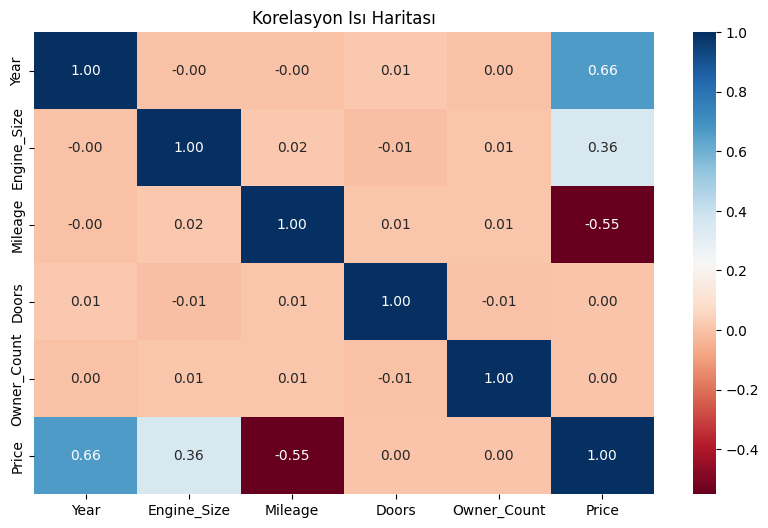

[]

In [31]:
high_correlated_cols2(df, plot=True)

In [32]:
corr = df[num_cols].corr()

In [33]:
corr

,Year,Engine_Size,Mileage,Price
Year,1.000,-0.001,-0.002,0.663
Engine_Size,-0.001,1.000,0.015,0.357
Mileage,-0.002,0.015,1.000,-0.551
Price,0.663,0.357,-0.551,1.000


# **11. Distribution of the Dependent Variable**

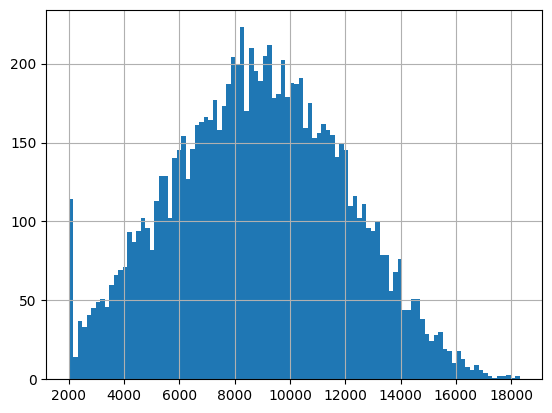

In [34]:
df["Price"].hist(bins=100)
plt.show(block=True)

# **12. Examining the Logarithm of the Dependent Variable**

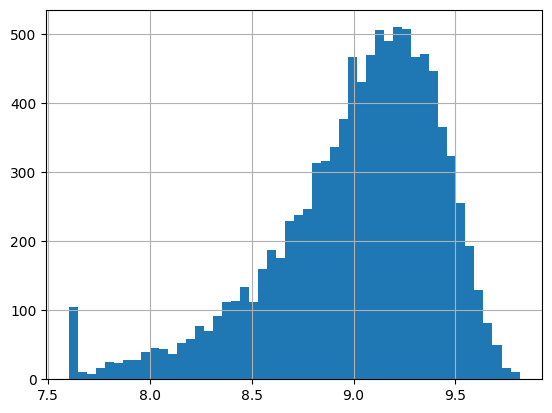

In [35]:
np.log1p(df['Price']).hist(bins=50)
plt.show(block=True)

# **13. Outliers Analysis**

In [36]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.78):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [37]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [38]:
for col in num_cols:
    print(col, check_outlier(df, col))

Year False
Engine_Size False
Mileage False
Price False


# **14. Missing Value Analysis**

In [39]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [40]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# **15. Rare Analysis**

In [41]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({'COUNT': dataframe[col].value_counts(),
                            'RATIO': dataframe[col].value_counts() / len(dataframe),
                            'TARGET_MEAN': dataframe.groupby(col)[target].mean()}), end='\n\n\n')

In [42]:
rare_analyser(df, "Price", cat_cols)

Brand : 10
            COUNT  RATIO  TARGET_MEAN
Brand                                
Audi         1038  0.104     8929.374
BMW           999  0.100     8704.068
Chevrolet    1003  0.100     9015.684
Ford         1048  0.105     8852.571
Honda        1009  0.101     8665.597
Hyundai       995  0.100     8778.279
Kia           976  0.098     8880.086
Mercedes      942  0.094     8980.087
Toyota        970  0.097     8798.185
Volkswagen   1020  0.102     8928.377


Model : 30
          COUNT  RATIO  TARGET_MEAN
Model                              
3 Series    335  0.034     8854.752
5 Series    353  0.035     8669.218
A3          338  0.034     8912.317
A4          350  0.035     8919.963
Accord      365  0.036     8743.762
...         ...    ...          ...
Sonata      319  0.032     8740.831
Sportage    313  0.031     8867.636
Tiguan      352  0.035     9098.864
Tucson      329  0.033     8789.070
X5          311  0.031     8581.312

[30 rows x 3 columns]


Fuel_Type : 4
           CO

In [43]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

In [44]:
rare_encoder(df, 0.01)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.200,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.000,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.200,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.000,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.600,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.700,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.400,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.000,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.400,Hybrid,Automatic,225772,4,1,4084


# **16. Feature Extraction**

In [45]:
df["Engine_Size"].value_counts()

,count
Engine_Size,
3.700,273
4.400,271
3.600,267
2.500,266
1.500,265
...,...
4.800,231
1.100,230
2.300,223


In [46]:
df["Engine_Size_Group"] = pd.cut(df["Engine_Size"], bins=3, labels=["Small", "Medium", "Large"])
df["Mileage_Group"] = pd.cut(df["Mileage"], bins=3, labels=["Low", "Medium", "High"])
df["Year_of_Registration_Group"] = pd.cut(df["Year"], bins=3, labels=["2000s", "2010s", "2020s"])

In [47]:
df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price,Engine_Size_Group,Mileage_Group,Year_of_Registration_Group
0,Kia,Rio,2020,4.200,Diesel,Manual,289944,3,5,8501,Large,High,2020s
1,Chevrolet,Malibu,2012,2.000,Hybrid,Automatic,5356,2,3,12092,Small,Low,2010s
2,Mercedes,GLA,2020,4.200,Diesel,Automatic,231440,4,2,11171,Large,High,2020s
3,Audi,Q5,2023,2.000,Electric,Manual,160971,2,1,11780,Small,Medium,2020s
4,Volkswagen,Golf,2003,2.600,Hybrid,Semi-Automatic,286618,3,3,2867,Medium,High,2000s


# **17. Encoding**

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Brand                       10000 non-null  object  
 1   Model                       10000 non-null  object  
 2   Year                        10000 non-null  int64   
 3   Engine_Size                 10000 non-null  float64 
 4   Fuel_Type                   10000 non-null  object  
 5   Transmission                10000 non-null  object  
 6   Mileage                     10000 non-null  int64   
 7   Doors                       10000 non-null  int64   
 8   Owner_Count                 10000 non-null  int64   
 9   Price                       10000 non-null  int64   
 10  Engine_Size_Group           10000 non-null  category
 11  Mileage_Group               10000 non-null  category
 12  Year_of_Registration_Group  10000 non-null  category
dtypes: category(3), f

In [49]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 10000
Variables: 13
cat_cols: 9
num_cols: 4
cat_but_car: 0
num_but_cat: 5


In [50]:
cat_cols

['Brand',
 'Model',
 'Fuel_Type',
 'Transmission',
 'Doors',
 'Owner_Count',
 'Engine_Size_Group',
 'Mileage_Group',
 'Year_of_Registration_Group']

In [51]:
num_cols

['Year', 'Engine_Size', 'Mileage', 'Price']

In [52]:
cat_but_car

[]

In [53]:
num_but_cat

['Doors',
 'Owner_Count',
 'Engine_Size_Group',
 'Mileage_Group',
 'Year_of_Registration_Group']

In [54]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [55]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [56]:
df.head()

,Year,Engine_Size,Mileage,Price,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Kia,Brand_Mercedes,Brand_Toyota,Brand_Volkswagen,Model_5 Series,Model_A3,Model_A4,Model_Accord,Model_C-Class,Model_CR-V,Model_Camry,Model_Civic,Model_Corolla,Model_E-Class,Model_Elantra,Model_Equinox,Model_Explorer,Model_Fiesta,Model_Focus,Model_GLA,Model_Golf,Model_Impala,Model_Malibu,Model_Optima,Model_Passat,Model_Q5,Model_RAV4,Model_Rio,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic,Doors_3,Doors_4,Doors_5,Owner_Count_2,Owner_Count_3,Owner_Count_4,Owner_Count_5,Engine_Size_Group_Medium,Engine_Size_Group_Large,Mileage_Group_Medium,Mileage_Group_High,Year_of_Registration_Group_2010s,Year_of_Registration_Group_2020s
0,2020,4.200,289944,8501,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,True,False,True
1,2012,2.000,5356,12092,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,2020,4.200,231440,11171,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,True
3,2023,2.000,160971,11780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
4,2003,2.600,286618,2867,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False


# **18. Standardization Process**

In [57]:
num_cols = [col for col in num_cols if col not in ["Price"]]

In [58]:
scaler = RobustScaler()

In [59]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [60]:
df.head(10)

,Year,Engine_Size,Mileage,Price,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Kia,Brand_Mercedes,Brand_Toyota,Brand_Volkswagen,Model_5 Series,Model_A3,Model_A4,Model_Accord,Model_C-Class,Model_CR-V,Model_Camry,Model_Civic,Model_Corolla,Model_E-Class,Model_Elantra,Model_Equinox,Model_Explorer,Model_Fiesta,Model_Focus,Model_GLA,Model_Golf,Model_Impala,Model_Malibu,Model_Optima,Model_Passat,Model_Q5,Model_RAV4,Model_Rio,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic,Doors_3,Doors_4,Doors_5,Owner_Count_2,Owner_Count_3,Owner_Count_4,Owner_Count_5,Engine_Size_Group_Medium,Engine_Size_Group_Large,Mileage_Group_Medium,Mileage_Group_High,Year_of_Registration_Group_2010s,Year_of_Registration_Group_2020s
0,0.727,0.600,0.942,8501,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,True,False,True
1,0.000,-0.500,-0.968,12092,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,0.727,0.600,0.550,11171,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,True
3,1.000,-0.500,0.076,11780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
4,-0.818,-0.200,0.920,2867,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False
5,-0.455,-0.150,0.056,7242,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False
6,-0.182,0.200,-0.067,11208,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False
7,-1.000,0.850,0.053,7950,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False
8,0.182,-0.200,-0.342,9926,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False

# **19. Creating Model**

In [61]:
y = df["Price"]

In [62]:
X = df.drop(["Price"], axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [67]:
models = [('LR', LinearRegression()),
          #('LogR', LogisticRegression()), # Removed LogisticRegression
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          #("XGBoost", XGBRegressor(objective='reg:squareerror')), # Removed XGBoost
          #("LightGBM", LGBMRegressor()), # Removed LightGBM
          ("CatBoost", CatBoostRegressor(verbose=False))]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

for name, regressor in models:
    start_time = time.time()

    # Fit the model
    regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = regressor.predict(X_test)

    # Calculate RMSE
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)

    # Calculate R^2 score
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate MAE
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

RMSE: 84.0394 (LR)
R^2 Score: 0.9986 (LR)
MAE: 23.7184 (LR)
MSE: 13446.0301 (LR)
Execution Time: 1.02 seconds

RMSE: 84.1326 (Ridge)
R^2 Score: 0.9986 (Ridge)
MAE: 25.1981 (Ridge)
MSE: 13399.4494 (Ridge)
Execution Time: 0.48 seconds

RMSE: 84.1952 (Lasso)
R^2 Score: 0.9986 (Lasso)
MAE: 26.4039 (Lasso)
MSE: 13379.8577 (Lasso)
Execution Time: 1.53 seconds

RMSE: 1704.9177 (ElasticNet)
R^2 Score: 0.7012 (ElasticNet)
MAE: 1365.0267 (ElasticNet)
MSE: 2860704.854 (ElasticNet)
Execution Time: 1.56 seconds

RMSE: 1246.6698 (KNN)
R^2 Score: 0.8392 (KNN)
MAE: 993.196 (KNN)
MSE: 1539064.0956 (KNN)
Execution Time: 0.27 seconds

RMSE: 865.5554 (CART)
R^2 Score: 0.9233 (CART)
MAE: 643.155 (CART)
MSE: 733823.08 (CART)
Execution Time: 0.53 seconds

RMSE: 542.0098 (RF)
R^2 Score: 0.9706 (RF)
MAE: 432.3398 (RF)
MSE: 281790.873 (RF)
Execution Time: 33.74 seconds

RMSE: 230.9394 (GBM)
R^2 Score: 0.9945 (GBM)
MAE: 180.348 (GBM)
MSE: 52473.7429 (GBM)
Execution Time: 8.32 seconds

RMSE: 53.1373 (CatBoost)
R^

# **20. Hyperparameter optimization**

Hyperparameter Tuning for LR:
RMSE: 115.957 (LR)
R^2 Score: 0.9986 (LR)
MAE: 23.7184 (LR)
MSE: 13446.0301 (LR)
Execution Time: 0.04 seconds

Hyperparameter Tuning for Ridge:
Best parameters: {'alpha': 0.1}
RMSE: 115.9324 (Ridge)
R^2 Score: 0.9986 (Ridge)
MAE: 23.8521 (Ridge)
MSE: 13440.3318 (Ridge)
Execution Time: 1.67 seconds

Hyperparameter Tuning for Lasso:
Best parameters: {'alpha': 0.1}
RMSE: 115.8793 (Lasso)
R^2 Score: 0.9986 (Lasso)
MAE: 23.5118 (Lasso)
MSE: 13428.0071 (Lasso)
Execution Time: 0.41 seconds

Hyperparameter Tuning for ElasticNet:
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
RMSE: 194.0222 (ElasticNet)
R^2 Score: 0.9961 (ElasticNet)
MAE: 146.9338 (ElasticNet)
MSE: 37644.6035 (ElasticNet)
Execution Time: 0.51 seconds

Hyperparameter Tuning for KNN:
Best parameters: {'n_neighbors': 5}
RMSE: 1240.5902 (KNN)
R^2 Score: 0.8392 (KNN)
MAE: 993.196 (KNN)
MSE: 1539064.0956 (KNN)
Execution Time: 0.52 seconds

Hyperparameter Tuning for CART:
Best parameters: {'max_depth': 

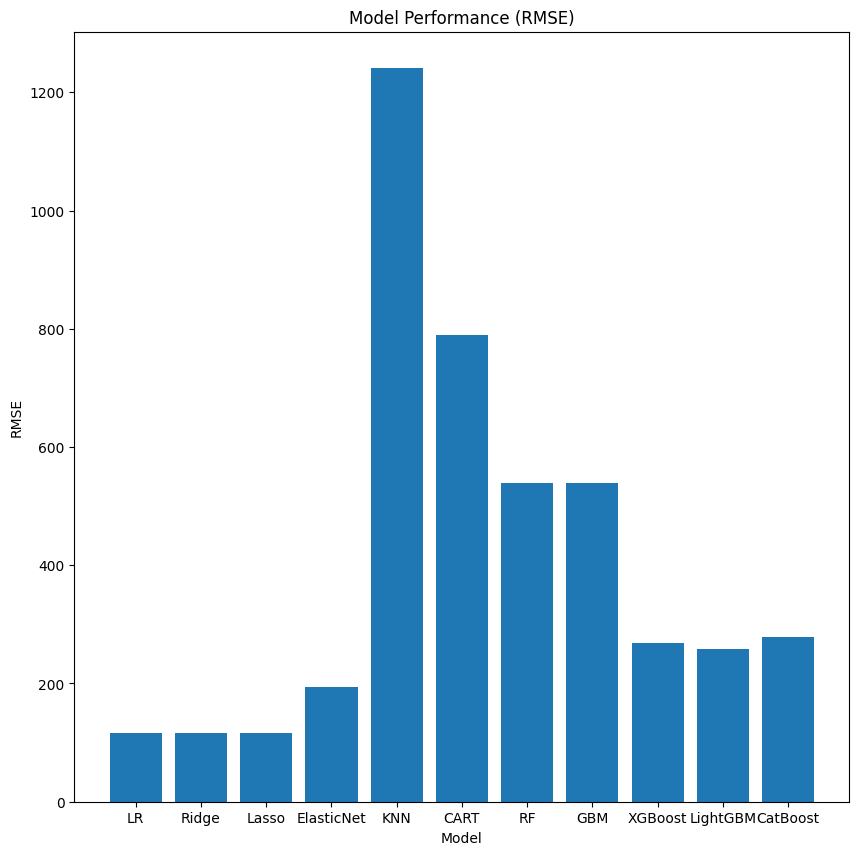

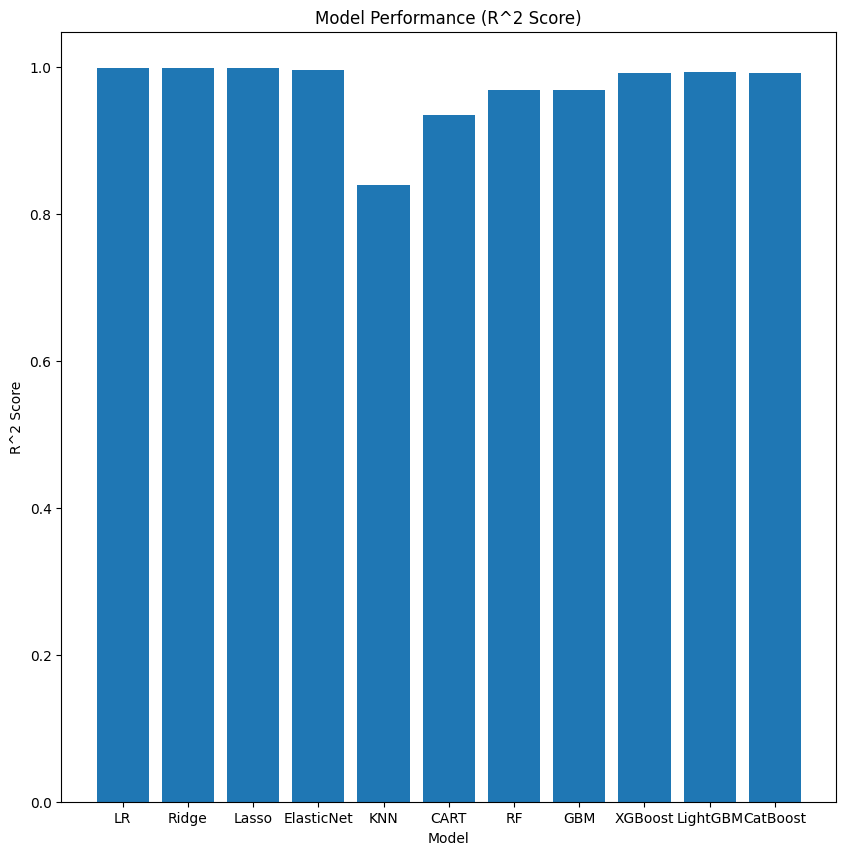

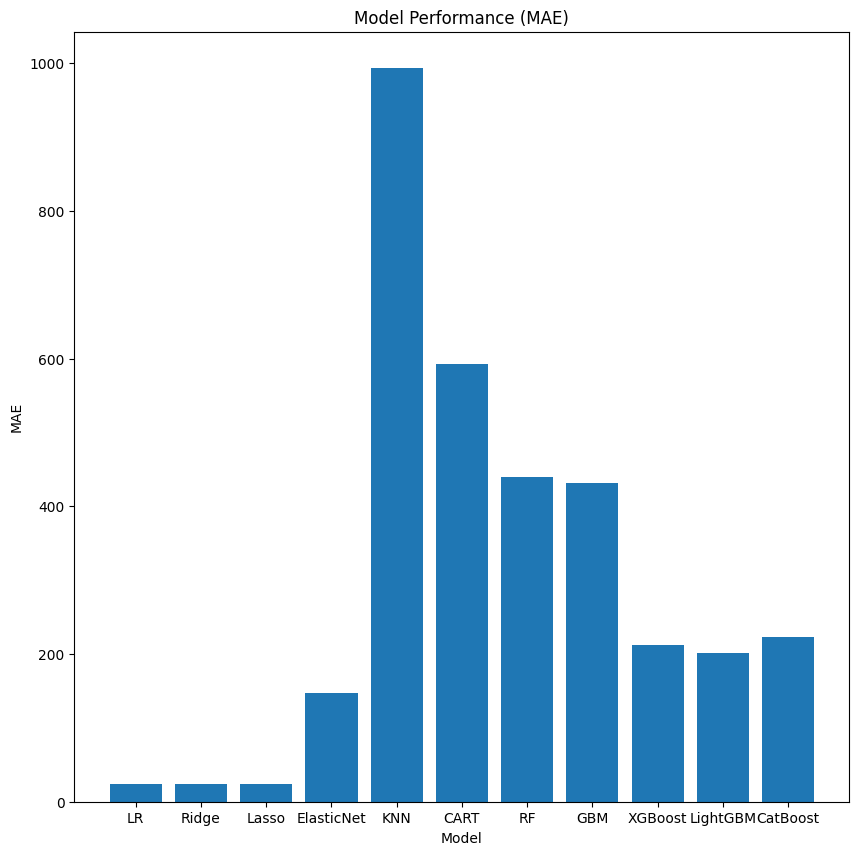

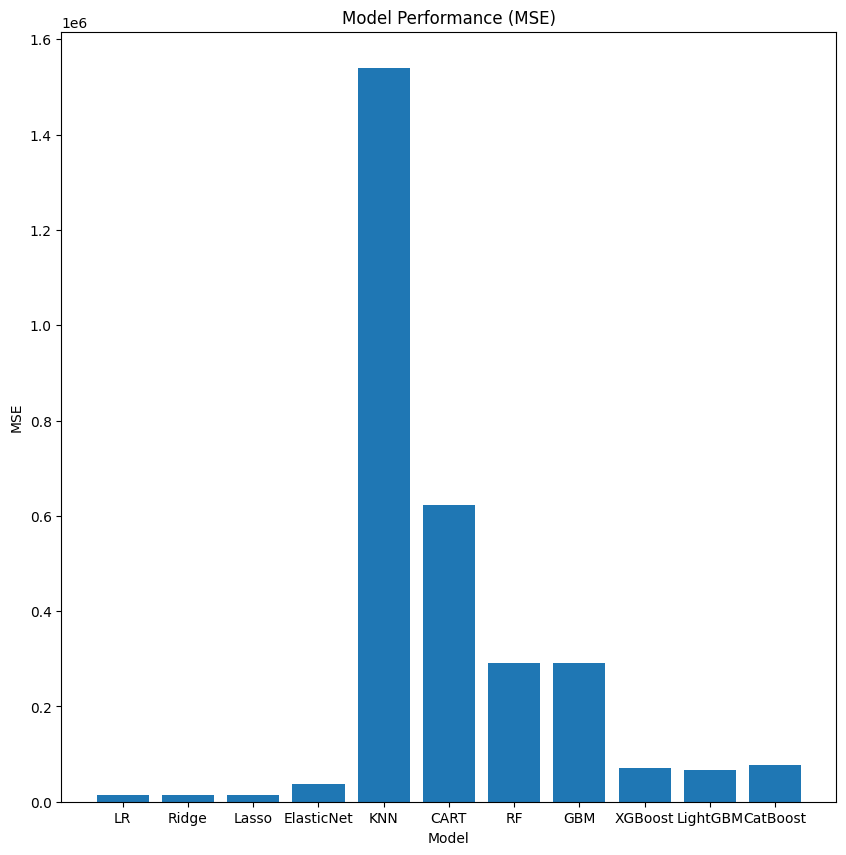

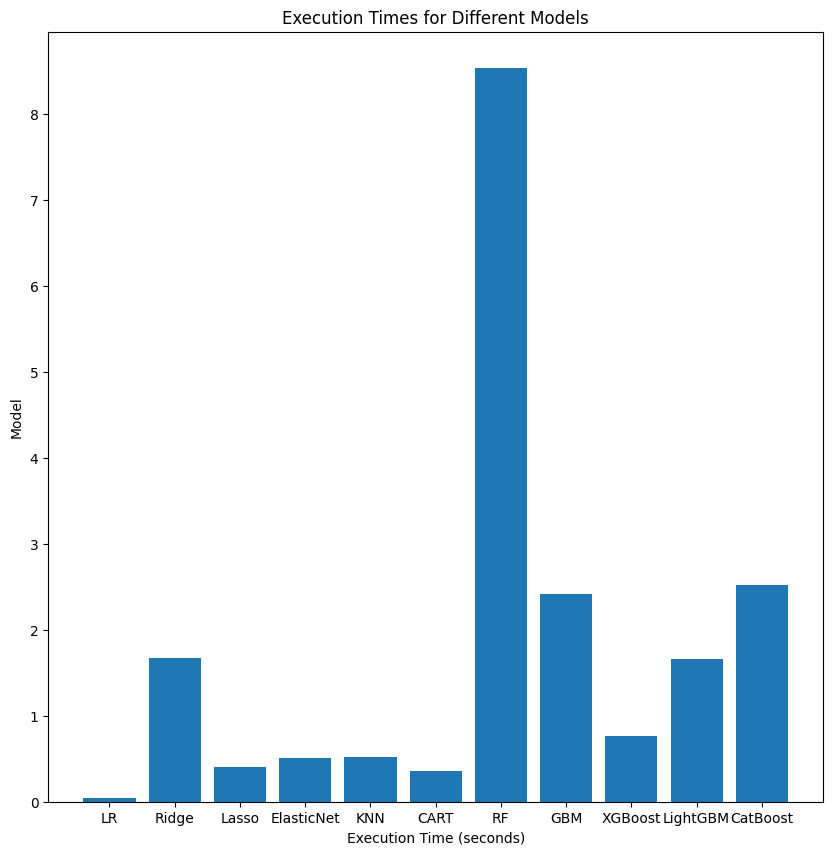

In [73]:
# Initialize the models
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

# Initialize lists to store metrics
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

# Define the hyperparameters for each model
param_grids = {
    'LR': {},
    'Ridge': {'alpha': [0.1, 1.0]},
    'Lasso': {'alpha': [0.1, 1.0]},
    'ElasticNet': {'alpha': [0.1, 1.0], 'l1_ratio': [0.1, 0.9]},
    'KNN': {'n_neighbors': [3, 5]},
    'CART': {'max_depth': [None, 10], 'min_samples_leaf': [1, 2]},
    'RF': {'n_estimators': [10, 50], 'max_depth': [None, 10]},
    'GBM': {'n_estimators': [10, 50], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators': [10, 50], 'learning_rate': [0.01, 0.1]},
    'LightGBM': {'n_estimators': [10, 50], 'learning_rate': [0.01, 0.1]},
    'CatBoost': {'iterations': [10, 50], 'learning_rate': [0.01, 0.1], 'depth': [4, 6]}
}

# Train and evaluate the models with hyperparameter tuning
for name, regressor in models:
    print(f"Hyperparameter Tuning for {name}:")
    start_time = time.time()

    if param_grids[name]:
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Calculate R^2 score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

# Plot RMSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], rmse_scores)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Performance (RMSE)")
plt.show()

# Plot R^2 scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], r2_scores)
plt.xlabel("Model")
plt.ylabel("R^2 Score")
plt.title("Model Performance (R^2 Score)")
plt.show()

# Plot MAE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mae_scores)
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("Model Performance (MAE)")
plt.show()

# Plot MSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mse_scores)
plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Model Performance (MSE)")
plt.show()

# Plot execution times
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], execution_times)
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Model")
plt.title("Execution Times for Different Models")
plt.show()

# **21. Final Model Predictions and Comparison with True Prices**

In [74]:
best_model

In [75]:
# Final Prediction Model
final_model = best_model

# Make predictions on the test set using the final model
y_final_pred = final_model.predict(X_test)
final_y_pred = (y_final_pred)
final_y_test =(y_test)

In [76]:
# Create a DataFrame with the predicted prices and true prices
results = pd.DataFrame({'Predicted Price': final_y_pred, 'True Price': final_y_test})

# Calculate the difference between the true prices and predicted prices and add a new column
results['Difference'] = results['True Price'] - results['Predicted Price']

# Display the results
print(results)

      Predicted Price  True Price  Difference
2688        10502.852       10308    -194.852
233          5432.489        5447      14.511
9099         8643.772        8732      88.228
8652         7719.112        7871     151.888
2842         9158.969        9144     -14.969
...               ...         ...         ...
4395        11495.335       11813     317.665
8669         4398.477        4465      66.523
7634        12458.263       12629     170.737
556          2853.127        2445    -408.127
8247        11308.017       11192    -116.017

[2000 rows x 3 columns]


# **22. Feature Importance**

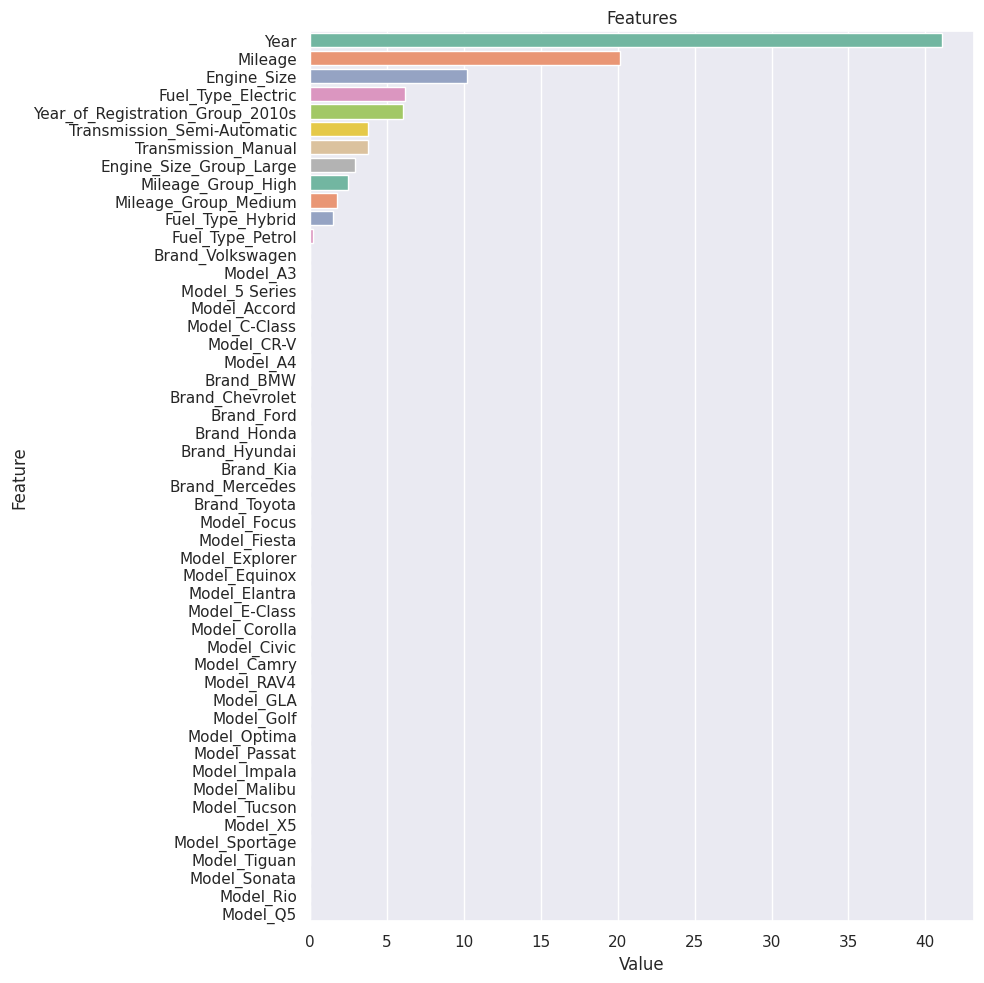

In [77]:
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", palette="Set2", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(final_model, X)